# Identifying the Drivers of Churn at Telco
***
## Goals

My goal for this project is to create a model that will acurrately predict customer churn using the customer data provided. I will also be identifying the primary drivers of customer churn.

I will deliver classification_project.ipynb, README.md, predictions.csv, acquire.py, prepare.py, model.py, a walkthrough-style presentation of the project. The deliverables listed here are detailed in-depth in the README file.

***
## Acquire
Acquire data from the customers table from the telco_churn database on the codeup data science database server.

In [4]:
# preparing environment

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# importing env for access to user, host and password
import acquire as ac

# display data frame
df = ac.get_telco_data()

df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes


***
## Prepare
Prepare, tidy, and clean the data so it can be explored and analyzed

In [6]:
# displaying column names, dtypes, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

- Categorical object variables such as gender, churn and dependents may need to be converted to 0s and 1s
- No missing values
    - Values with only white space may exist however
- Rename tenure to reflect unit of measurement
- Convert total_charges to float

In [7]:
# displaying various values for numerical columns (average, quartiles, min, max, etc)
# this allows us to get a rough idea of the values within the columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


- Senior_citizen: seniors are a minority
- Tenure: 72 month max means we have no records older than 6 years
- Type_ids for internet_service, contract, and paymenta are already numerical so no need to convert
- Monthly_charges: the average monthly payment is 64.76

In [8]:
# displaying unique values per column to identify categorical variables
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    if col != 'customer_id' and col != 'total_charges':
        print(df[col].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64
No                     2785
Yes                    2732
No internet servic

- columns with 2 values may need to be converted to 0s and 1s
- columns with 3 or 4 values may need to be converted to numerical values

__Outliers and distributions__

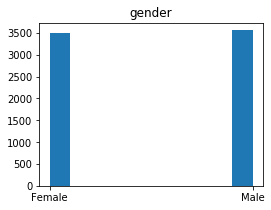

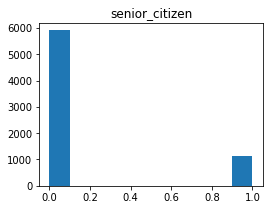

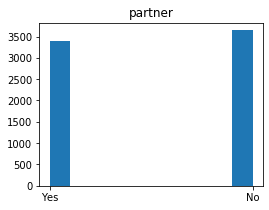

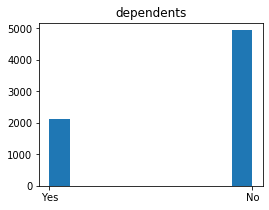

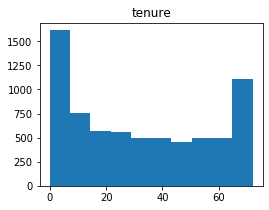

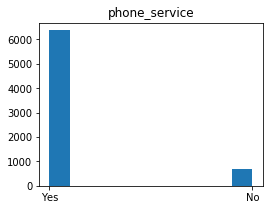

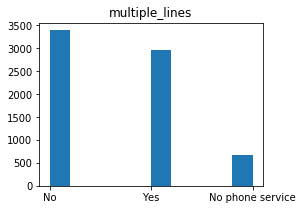

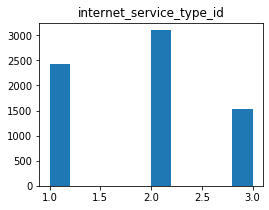

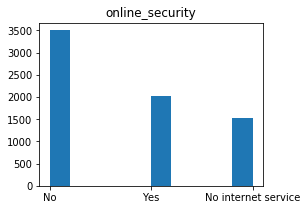

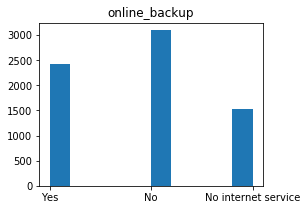

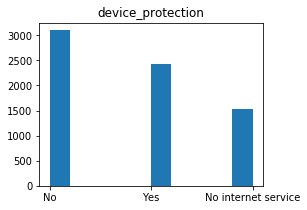

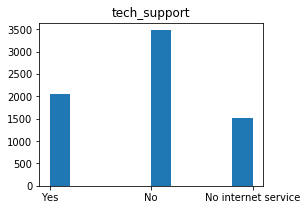

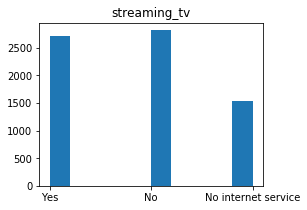

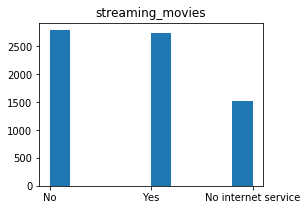

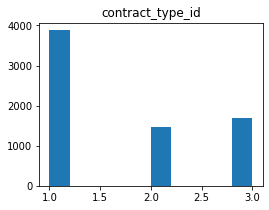

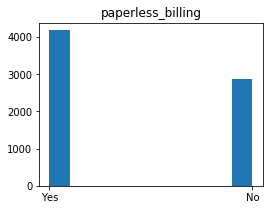

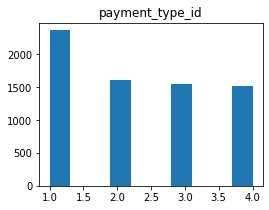

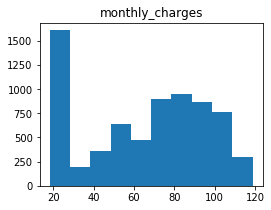

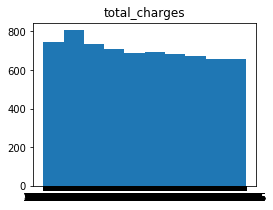

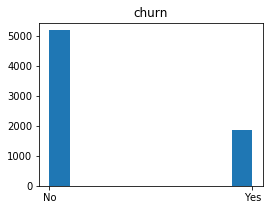

In [9]:
# plotting data to identify outliers and distributions
for col in df.columns:
    if col != 'customer_id':
        plt.figure(figsize=(4,3))
        plt.hist(df[col])
        plt.title(col)
        plt.show()

- No outliers found
- Customers without phone service and seniors are minorities
- Fairly even split between male and female
- Monthly_charges would be a somewhat normal distribution if not for the extremely high amount of low payment customers

__Prepare.py__

- convert object columns with binary values to 0s and 1s
- convert object columns with 3 - 4 unique values to numerical via dummy_df
- rename tenure to tenure_months
- add columns for tenure years
- remove duplicates
- convert total_charges to float
- __merge columns where needed__
- check for white space values
    * remove rows if small amount ( =< 10 )
    * fill with most common value otherwise
- split into train, validate, test

In [21]:
from acquire import get_telco_data
from prepare import prepare_telco

train, validate, test = prepare_telco(get_telco_data())